In [2]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

   Resolving package versions...
    Updating `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/pancreas/Project.toml`
  [d47a2e43] ~ locaTE v0.2.5 `~/stephenz/locaTE.jl` ⇒ v0.2.7 `~/stephenz/locaTE.jl`
    Updating `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/pancreas/Manifest.toml`
  [d47a2e43] ~ locaTE v0.2.5 `~/stephenz/locaTE.jl` ⇒ v0.2.7 `~/stephenz/locaTE.jl`
  [dad2f222] ↑ LLVMExtra_jll v0.0.16+0 ⇒ v0.0.16+2


In [3]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA
using Random
using NNlib

[ Info: Precompiling locaTE [d47a2e43-82e6-47ba-a340-eddb77145d33]
[ Info: Precompiling Graphs [86223c79-3864-5bf0-83f7-82e725a168b6]
[ Info: Precompiling GraphSignals [3ebe565e-a4b5-49c6-aed2-300248c3a9c1]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


In [4]:
DATA_DIR = "../../data/pancreas/"
X = npzread(string(DATA_DIR, "X.npy"))
TE = npzread("TE_locate.npy");
L = sparse(npzread("L_locate.npy"));
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0;

In [5]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     16; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 10_000, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);
npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:06:27m


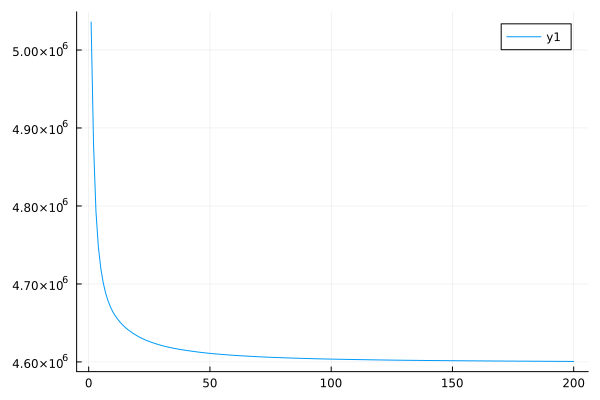

In [6]:
plot(trace)

In [ ]:
# NTF
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
                     [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
                     cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
                     [1, 1, 1],
                     [1, 1, 1],
                     10.0,
                     0.0,
                     36; iter = 500, dictionary = false, η = 1.0);

In [8]:
for i = 1:length(A)
    npzwrite("A_$i.npy", Array(A[i]))
end

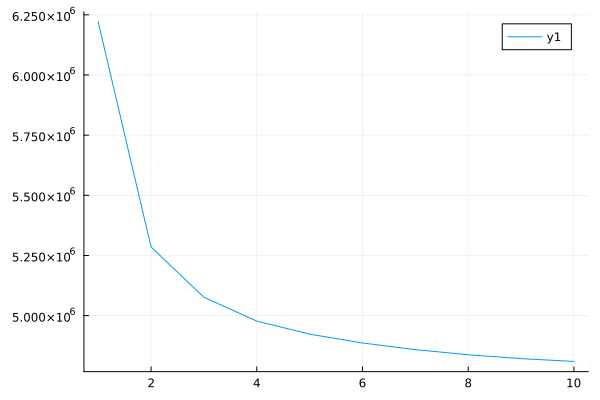

In [9]:
plot(trace)